 UNIVERSITY EVENT RECOMMENDER SYSTEM
Loading dataset...
Labeled dataset saved as 'labeled_dropNewone.csv'
Dataset shape: (220, 20)
Features: (220, 17), Labels: (220,)

TRAINING MODEL
Training set: 176 samples
Test set: 44 samples

Training for 100 epochs...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.2357 - loss: 1.4340 - val_accuracy: 0.5556 - val_loss: 1.2409
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4357 - loss: 1.2499 - val_accuracy: 0.7500 - val_loss: 1.0836
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6500 - loss: 1.0897 - val_accuracy: 0.7500 - val_loss: 0.9491
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6786 - loss: 0.9699 - val_accuracy: 0.7500 - val_loss: 0.8340
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6786 - loss: 0.8803 - val_accuracy: 0.7500 - val_loss: 0.7430
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6929 - loss: 0.8010 - val_accuracy: 0.7500 - va

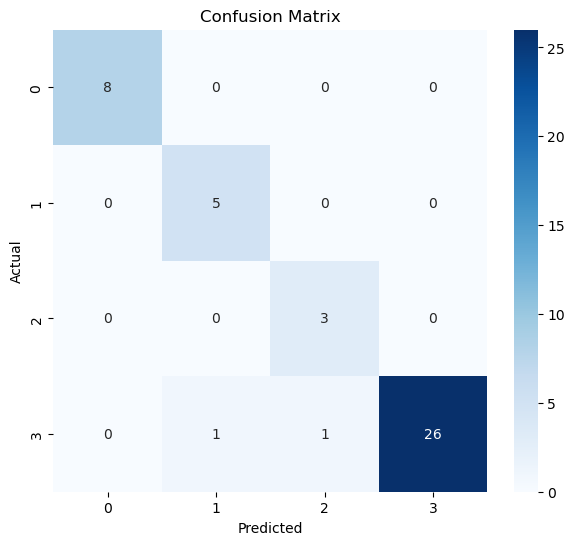

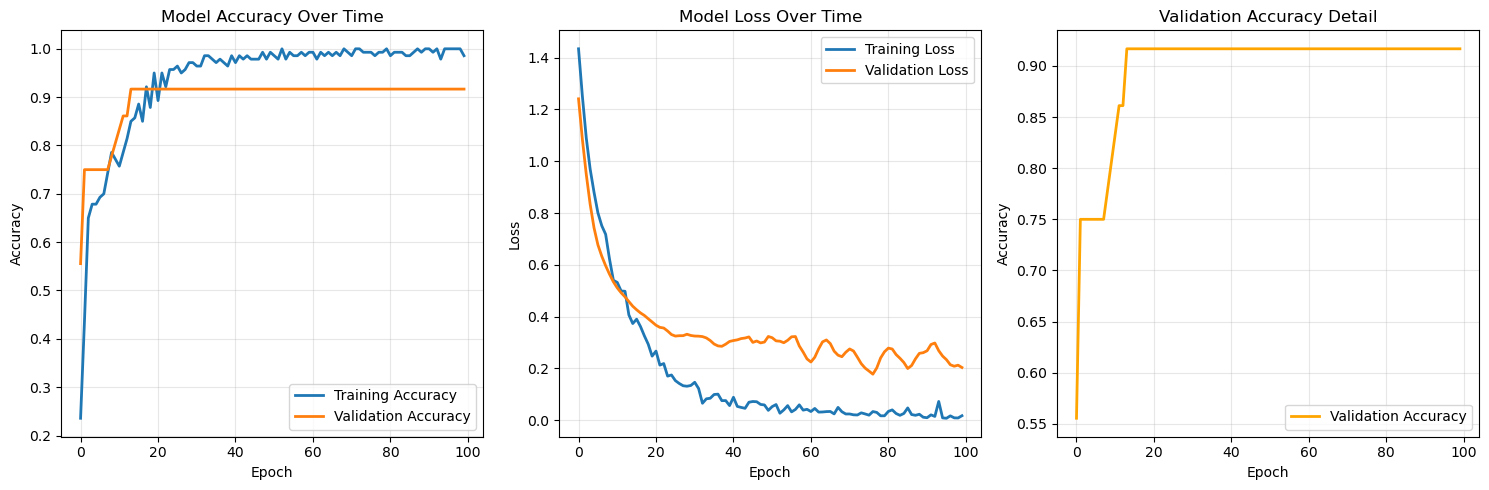


EXAMPLE PREDICTIONS
1. Test Student 1
   Predicted: Cultural & Social
   Actual: Cultural & Social
   Confidence: 1.000
   
2. Test Student 2
   Predicted: Cultural & Social
   Actual: Cultural & Social
   Confidence: 1.000
   
3. Test Student 3
   Predicted: Cultural & Social
   Actual: Cultural & Social
   Confidence: 1.000
   
4. Test Student 4
   Predicted: Cultural & Social
   Actual: Cultural & Social
   Confidence: 1.000
   
5. Test Student 5
   Predicted: Cultural & Social
   Actual: Cultural & Social
   Confidence: 1.000
   
6. Test Student 6
   Predicted: Academic & Career
   Actual: Academic & Career
   Confidence: 1.000
   
7. Test Student 7
   Predicted: Cultural & Social
   Actual: Cultural & Social
   Confidence: 1.000
   
8. Test Student 8
   Predicted: Cultural & Social
   Actual: Cultural & Social
   Confidence: 0.614
   
9. Test Student 9
   Predicted: Cultural & Social
   Actual: Cultural & Social
   Confidence: 1.000
   
10. Test Student 10
   Predicted: Academic 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

class UniversityEventRecommender:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.event_categories = {
            0: 'Academic & Career',
            1: 'Technical & Innovation',
            2: 'Sports & Physical Wellness',
            3: 'Cultural & Social',
        }
        self.feature_columns = []  # To store the exact feature columns used

    def load_and_preprocess_data(self, csv_file_path):
        print("Loading dataset...")
        df = pd.read_csv(csv_file_path)
        df = df.fillna(0)

        # Feature columns
        feature_columns = ['GPA', 'Interest_AcademicWorkshop', 'Interest_CareerDev', 
                           'Interest_SocialActivities', 'Interest_Sports',          
                           'Interest_CulturalPrograms', 'Interest_TechMeetups',       
                           'ParticipatedBefore', 'EventTypesAttended',         
                           'Hypo_TechWorkshop', 'Hypo_ResumeWorkshop',        
                           'Hypo_CulturalNight', 'Hypo_SportsTournament',     
                           'Hypo_SocialCampaign', 'Personality',                
                           'InterestTopics', 'SkillsToDevelop']

        # Filter only existing columns in dataset
        feature_columns = [col for col in feature_columns if col in df.columns]
        self.feature_columns = feature_columns  # Save feature columns list for later use in prediction
        X = df[feature_columns].values
        y = self.create_labels(df)

        df['Label'] = y
        labeled_csv_path = "labeled_" + csv_file_path
        df.to_csv(labeled_csv_path, index=False)
        print(f"Labeled dataset saved as '{labeled_csv_path}'")

        print(f"Dataset shape: {df.shape}")
        print(f"Features: {X.shape}, Labels: {y.shape}")
        return X, y

    # Label calculation method
    def create_labels(self, df):
        labels = []
        for _, row in df.iterrows():
            participated_score = row.get('ParticipatedBefore', 0)

            academic_score = (
                row.get('Interest_AcademicWorkshop', 0) +
                row.get('Interest_CareerDev', 0)  +
                row.get('Hypo_ResumeWorkshop', 0)  +
                participated_score
            )
            technical_score = (
                row.get('Interest_TechMeetups', 0) +
                row.get('Hypo_TechWorkshop', 0) +
                participated_score
            )
            sports_score = (
                row.get('Interest_Sports', 0) +
                row.get('Hypo_SportsTournament', 0) +
                participated_score
            )
            cultural_score = (
                row.get('Interest_CulturalPrograms', 0) +
                row.get('Interest_SocialActivities', 0) +
                row.get('Hypo_CulturalNight', 0) +
                row.get('Hypo_SocialCampaign', 0) +
                participated_score
            )
            
            scores = [academic_score, technical_score, sports_score, cultural_score]

            if max(scores) == 0:
                gpa = row.get('GPA', 0.5)
                label = 1 if gpa > 0.7 else 0
            else:
                label = scores.index(max(scores))

            labels.append(label)

        return np.array(labels)

    # Model Development
    def build_model(self, input_dim, num_classes=4):   
        model = Sequential([
            Dense(128, input_shape=(input_dim,), activation='relu'),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    # Plot training history with visualization
    def plot_training_history(self, history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        plt.title('Model Accuracy Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 2)
        plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        plt.title('Model Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 3)
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
        plt.title('Validation Accuracy Detail')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Confusion Matrix plot
    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    
    # Train the Model
    def train_model(self, X, y, test_size=0.2, epochs=100):
        print("\n" + "="*50)
        print("TRAINING MODEL")
        print("="*50)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"Training set: {X_train_scaled.shape[0]} samples")
        print(f"Test set: {X_test_scaled.shape[0]} samples")

        self.model = self.build_model(X_train_scaled.shape[1])

        print(f"\nTraining for {epochs} epochs...")
        history = self.model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=epochs,
            batch_size=32,
            verbose=1
        )

        print("\n" + "="*50)
        print("MODEL EVALUATION")
        print("="*50)

        y_pred = self.model.predict(X_test_scaled, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        accuracy = accuracy_score(y_test, y_pred_classes)
        precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)

        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")

        print("\nDetailed Classification Report:")
        target_names = [self.event_categories[i] for i in range(len(self.event_categories))]
        print(classification_report(y_test, y_pred_classes, target_names=target_names, zero_division=0))

        # Plot confusion matrix
        self.plot_confusion_matrix(y_test, y_pred_classes)

        self.plot_training_history(history)
        return history

    def predict_event_category(self, student_data):
        if self.model is None:
            raise ValueError("Model not trained yet.")

        # Convert input list to DataFrame using saved feature columns to ensure correct order & count
        student_df = pd.DataFrame([student_data], columns=self.feature_columns)
        student_data_scaled = self.scaler.transform(student_df)

        prediction = self.model.predict(student_data_scaled, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = np.max(prediction[0])

        return {
            'category': self.event_categories[predicted_class],
            'confidence': confidence,
            'all_probabilities': {
                self.event_categories[i]: float(prob)
                for i, prob in enumerate(prediction[0])
            }
        }

def main():
    print(" UNIVERSITY EVENT RECOMMENDER SYSTEM")
    print("="*50)

    recommender = UniversityEventRecommender()
    csv_file_path = 'dropNewone.csv'

    try:
        X, y = recommender.load_and_preprocess_data(csv_file_path)
        history = recommender.train_model(X, y, epochs=100)

        print("\n" + "="*50)
        print("EXAMPLE PREDICTIONS")
        print("="*50)

        # Use actual test dataset examples for predictions
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=0, stratify=y
        )

        # Select 5 random examples from test set
        np.random.seed(42)  # For reproducible selection
        test_indices = np.random.choice(len(X_test), size=10, replace=False)
        example_students = [X_test[i] for i in test_indices]
        actual_labels = [y_test[i] for i in test_indices]

        labels = [
            "Test Student 1",
            "Test Student 2",
            "Test Student 3",
            "Test Student 4",
            "Test Student 5",
            "Test Student 6",
            "Test Student 7",
            "Test Student 8",
            "Test Student 9",
            "Test Student 10",
        ]

        for i, (student_data, label, actual_label) in enumerate(zip(example_students, labels, actual_labels)):
            result = recommender.predict_event_category(student_data)
            actual_category = recommender.event_categories[actual_label]
            print(f"{i+1}. {label}")
            print(f"   Predicted: {result['category']}")
            print(f"   Actual: {actual_category}")
            print(f"   Confidence: {result['confidence']:.3f}")
            correct = "" if result['category'] == actual_category else ""
            print(f"   {correct}")

        print("\n Training completed successfully!")

    except FileNotFoundError:
        print(f" Error: Could not find '{csv_file_path}'")
        print("Please ensure the CSV file is in the correct location.")
    except Exception as e:
        print(f" Error: {str(e)}")

if __name__ == "__main__":
    main()
